In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models

# Set the image size
img_size = (64, 64)


In [4]:
def load_images(folder_path, img_size):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    return np.array(images)

# Load images from the 'images' folder
images = load_images('images', img_size)
print(f"Loaded {len(images)} images with shape: {images.shape}")


Loaded 1193 images with shape: (1193, 64, 64, 3)


In [5]:
def build_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')  # Adjust output units for your classification task
    ])
    return model

# Build and summarize the model
input_shape = (img_size[0], img_size[1], 3)
cnn_model = build_cnn_model(input_shape)
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

1/1 [==============================] - 0s 218ms/step


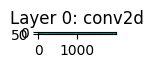

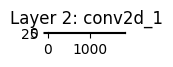

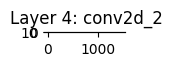

In [6]:
def visualize_feature_maps(model, images, layer_indices):
    # Create a model that gives output at each convolutional layer
    layer_outputs = [model.layers[i].output for i in layer_indices]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    
    # Pick a random image from the dataset
    img = images[np.random.randint(len(images))]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    # Get feature maps
    feature_maps = activation_model.predict(img)
    
    for layer_idx, fmap in zip(layer_indices, feature_maps):
        num_filters = fmap.shape[-1]
        size = fmap.shape[1]
        
        # Display all feature maps in this layer
        display_grid = np.zeros((size, size * num_filters))
        for i in range(num_filters):
            fmap_img = fmap[0, :, :, i]
            fmap_img -= fmap_img.mean()
            fmap_img /= (fmap_img.std() + 1e-5)
            fmap_img *= 64
            fmap_img += 128
            fmap_img = np.clip(fmap_img, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = fmap_img
        
        # Plot the feature maps
        scale = 1.0 / num_filters
        plt.figure(figsize=(scale * num_filters, scale))
        plt.title(f'Layer {layer_idx}: {model.layers[layer_idx].name}')
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

# Select layers to visualize (all convolutional layers)
layer_indices = [0, 2, 4]
visualize_feature_maps(cnn_model, images, layer_indices)


In [7]:
def build_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Adjust output units for classification
    ])
    return model

# Define input shape and number of classes
input_shape = (img_size[0], img_size[1], 3)
num_classes = 10  # Change this to match your dataset

# Build and summarize the model
custom_cnn = build_custom_cnn(input_shape, num_classes)
custom_cnn.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 128)        

In [8]:
custom_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Dummy labels for illustration. Replace with your actual labels.
labels = np.random.randint(0, num_classes, len(images))

# One-hot encode labels
labels = to_categorical(labels, num_classes)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")


Training set: (954, 64, 64, 3), Validation set: (239, 64, 64, 3)


In [10]:
history = custom_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)


Epoch 1/20
30/30 [==============================] - 3s 83ms/step - loss: 2.3104 - accuracy: 0.0975 - val_loss: 2.2999 - val_accuracy: 0.1423
Epoch 2/20
30/30 [==============================] - 2s 76ms/step - loss: 2.3014 - accuracy: 0.1226 - val_loss: 2.2991 - val_accuracy: 0.1423
Epoch 3/20
30/30 [==============================] - 2s 71ms/step - loss: 2.2990 - accuracy: 0.1174 - val_loss: 2.2981 - val_accuracy: 0.1423
Epoch 4/20
30/30 [==============================] - 2s 77ms/step - loss: 2.2995 - accuracy: 0.1153 - val_loss: 2.2972 - val_accuracy: 0.1423
Epoch 5/20
30/30 [==============================] - 2s 75ms/step - loss: 2.3001 - accuracy: 0.1258 - val_loss: 2.2933 - val_accuracy: 0.1423
Epoch 6/20
30/30 [==============================] - 2s 74ms/step - loss: 2.3020 - accuracy: 0.1216 - val_loss: 2.2977 - val_accuracy: 0.1423
Epoch 7/20
30/30 [==============================] - 2s 78ms/step - loss: 2.3004 - accuracy: 0.1143 - val_loss: 2.2971 - val_accuracy: 0.1423
Epoch 8/20
30

In [11]:
# Evaluate model performance
val_loss, val_accuracy = custom_cnn.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


8/8 [==============================] - 0s 28ms/step - loss: 2.2950 - accuracy: 0.1423
Validation Accuracy: 14.23%


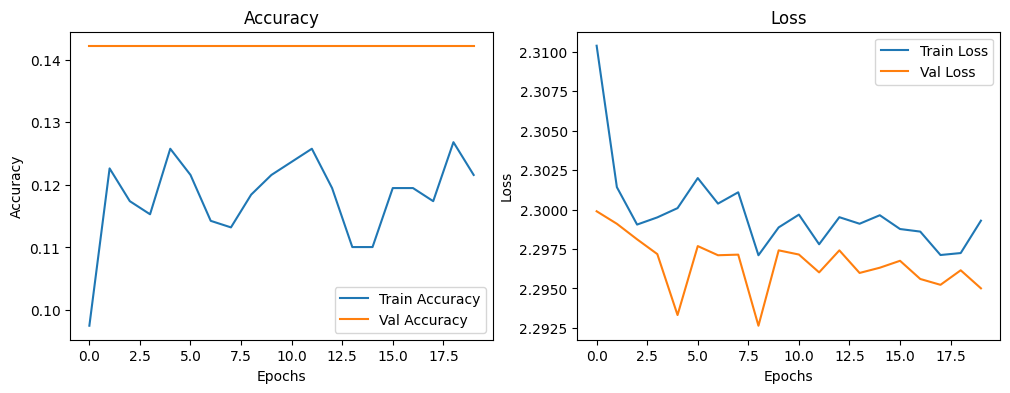

In [12]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
